# Demo of RtDeep

We define a simple network using RtDeep with microcircuits.

2 kinds of tasks:
- learn to adapt the backward weights to transpose of forward weights
- learn to reproduce output of a teacher network.

The model uses real time dynamics with Euler integration, LE, dendritic error propagation and a phased implementation of L-DRL.

## Definitions

In [1]:
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=12,family='serif')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from microcircuit import *
import sys
# import pandas as pd


#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport microcircuit

# Learn $B = W^T$ in tiny net

We add tiny noise to the hidden layer in a network [1-2-1] and learn the backwards weights to align with $(W^\mathrm{PP})^T$.

In particular, to make it easier to identify if the task is performed succesfully, we initialise $B^\mathrm{PP}$ with negative entries, and $(W^\mathrm{PP})^T$ with positive values.

### Setup

In [3]:
# simulation settings

dt     = 1e-3 # in ms
dtxi   = 10 * dt
tausyn = dtxi
Tpres  = 1e+3 * dt # present images for 1 ms
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 200 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * uP
noise_scale = [5e-2]

np.random.seed(12345)

# Init model: weights, voltages

layers = [1, 2, 1]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [500.0] * (len(layers) - 2)
eta_IP = [20.0] * (len(layers) - 1)
eta_PI = [1.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [1e-4]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))
    
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

# instantiate the model

mc1 = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=False,
                         gate_regularizer=True, noise_mode='uP', model='LDRL',
                         activation=relu, layers=layers,
                         uP_init=uP_init, uI_init=uI_init,
                         WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
                         gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
                         eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

### Simulation

In [4]:
# # pre-training to settle voltages
# for i in range(len(r0_random)):
#     mc1.evolve_system(r0=r0_random[i], learn_weights=False, learn_bw_weights=False)

In [6]:
mc1.init_record(rec_per_steps=10, rec_WPP=True, rec_WIP=True, rec_BPP=True, rec_BPI=True, rec_rI_breve=True, rec_rP_breve=True, rec_vapi=True)

for i in range(len(r0_random)):
    mc1.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP

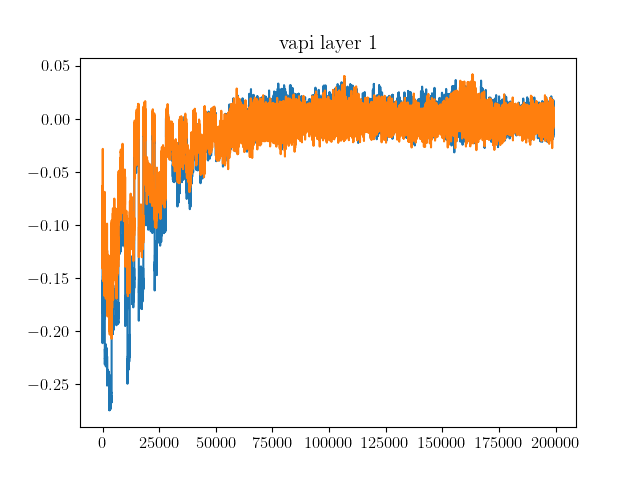

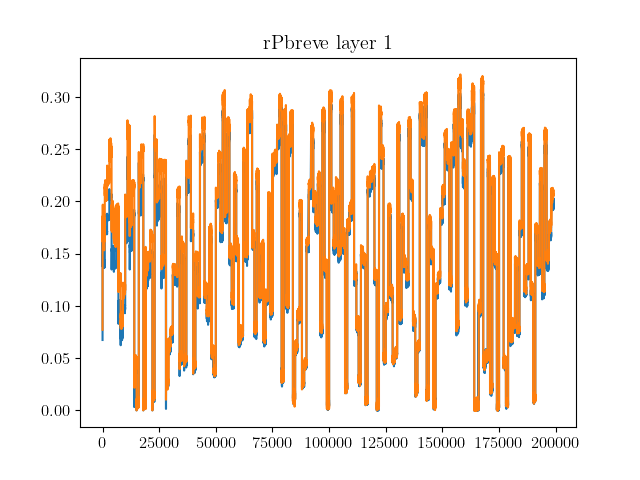

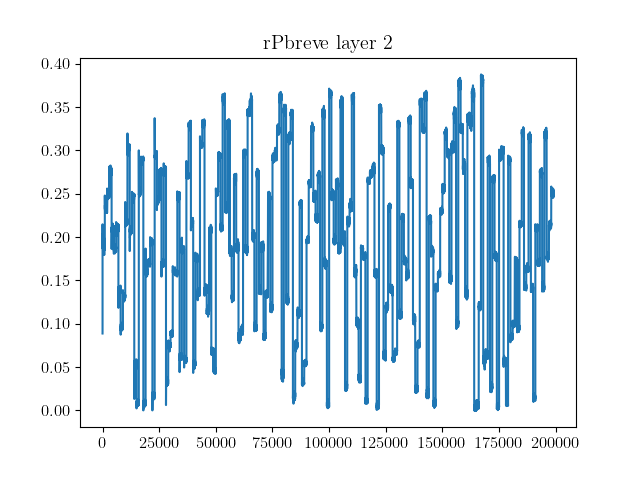

In [7]:
fig = plt.figure()
for i in range(len(mc1.vapi_time_series[0][0])):
    vec = [vec[0][i] for vec in mc1.vapi_time_series]
    plt.plot(np.array(vec[int(Tpres/dt):]).ravel())
plt.title("vapi layer 1")
plt.show()

fig = plt.figure()
for i in range(len(mc1.rP_breve_time_series[0][0])):
    vec = [vec[0][i] for vec in mc1.rP_breve_time_series]
    plt.plot(np.array(vec[int(Tpres/dt):]).ravel())
plt.title("rPbreve layer 1")
plt.show()

fig = plt.figure()
for i in range(len(mc1.rP_breve_time_series[0][1])):
    vec = [vec[1][i] for vec in mc1.rP_breve_time_series]
    plt.plot(np.array(vec[int(Tpres/dt):]).ravel())
plt.title("rPbreve layer 2")
plt.show()

Check that BPP and BPI learn at ~ same speed:

In [8]:
print(mc1.dWIP[0])
print(mc1.dBPP[0].T)
print(mc1.dBPI[0].T)

[[1.19174359e-07 1.24860575e-07]]
[[2.00663910e-07 9.67575288e-07]]
[[5.22279726e-07 7.48353942e-07]]


Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [9]:
STEPS = 1

mc1.cos_BPI_BPP = []
for i in range(len(mc1.BPI_time_series[0])):
    mc1.cos_BPI_BPP.append(np.array([
        cos_sim(mc1.BPI_time_series[j][i], -mc1.BPP_time_series[j][i]) for j in range(0, len(mc1.BPI_time_series), STEPS)
                           ]))
    
mc1.cos_WIP_WPP = []
for i in range(len(mc1.WIP_time_series[0])):
    mc1.cos_WIP_WPP.append(np.array([
        cos_sim(mc1.WIP_time_series[j][i], mc1.WPP_time_series[j][i+1]) for j in range(0, len(mc1.WIP_time_series), STEPS)
                           ]))
    
mc1.cos_WPPtrans_BPP = []
for i in range(len(mc1.BPP_time_series[0])):
    mc1.cos_WPPtrans_BPP.append(np.array([
        cos_sim(mc1.BPP_time_series[j][i], mc1.WPP_time_series[j][i+1].T) for j in range(0, len(mc1.BPP_time_series), STEPS)
                           ]))

BPP at init:

In [10]:
mc1.BPP_time_series[0][0]

array([[-0.25228519],
       [-0.03869326]])

BPP after learning:

In [11]:
mc1.BPP_time_series[-1][0]

array([[0.14688443],
       [0.13801322]])

WPP^T (fixed):

In [18]:
mc1.WPP_time_series[0][1].T

array([[0.96451452],
       [0.6531771 ]])

Plot cos between $B$ and $W^T$, and actual entries (Note: the algorithm only *aligns* $B$ with $W^T$ -- it doesn't also set it to the same scale.)

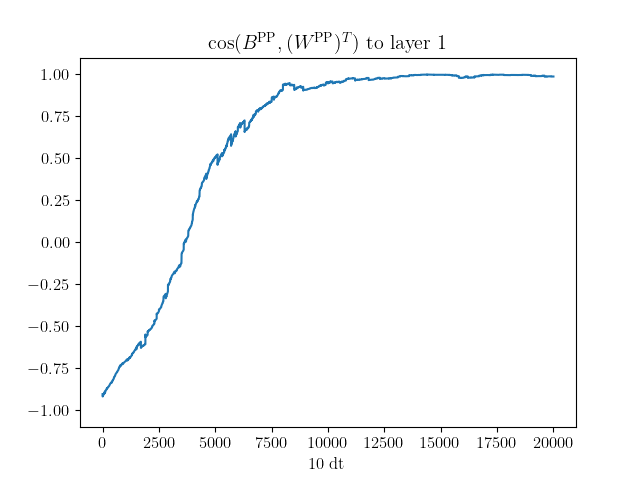

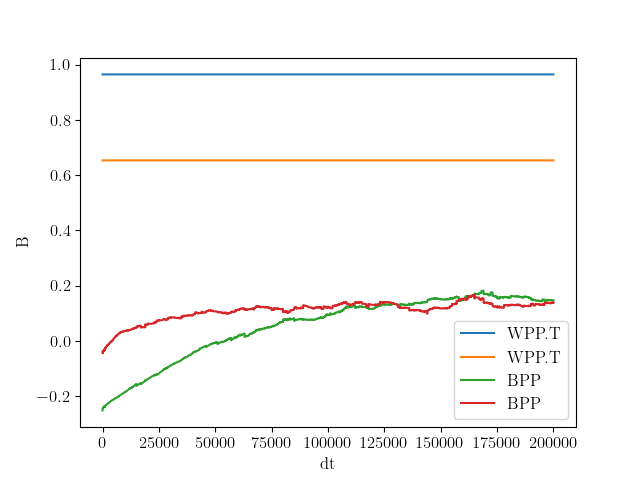

In [13]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_WPPtrans_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    
    fig, ax = plt.subplots()
    ax.plot([WPP[i+1].T.ravel() for WPP in mc1.WPP_time_series], label="WPP.T")
    ax.plot([BPP[i].ravel() for BPP in mc1.BPP_time_series], label="BPP")
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

We also check if the self-predicting state has been learnt correctly:

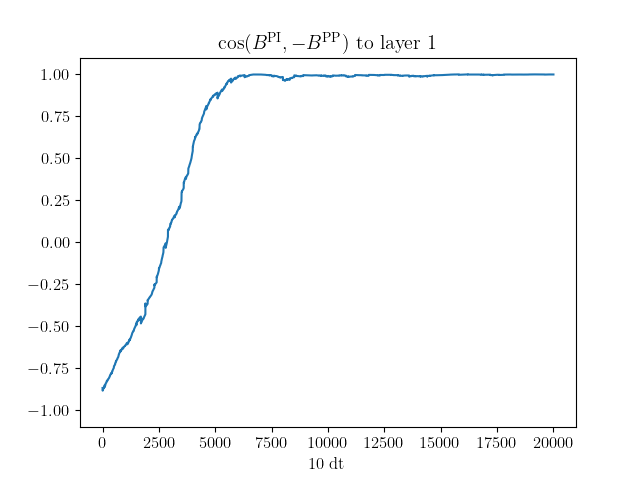

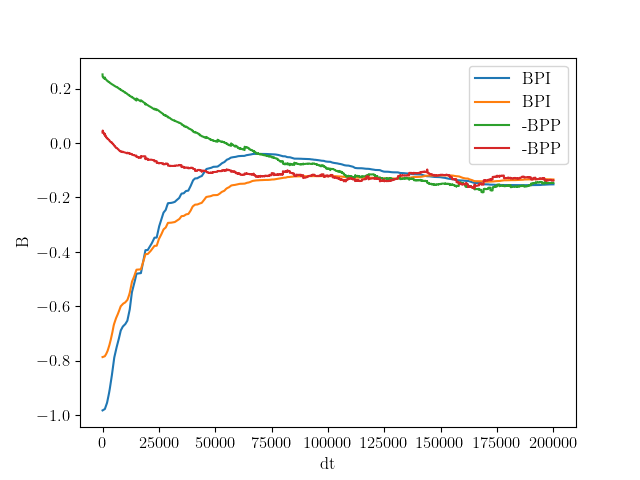

In [14]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_BPI_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([BPI[i].ravel() for BPI in mc1.BPI_time_series], label="BPI")
    ax.plot([-BPP[i].ravel() for BPP in mc1.BPP_time_series], label="-BPP")
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

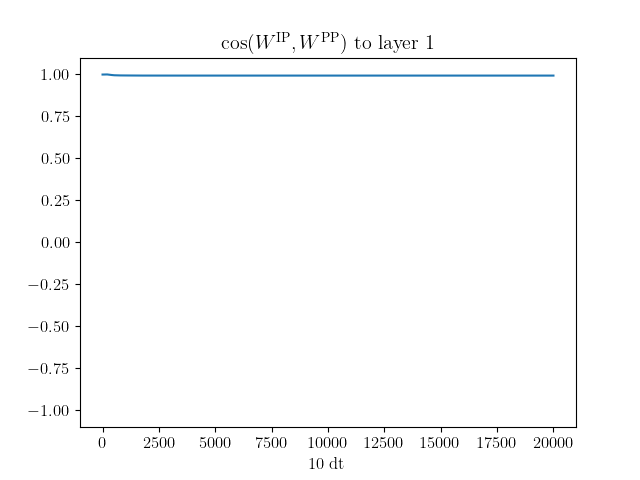

In [15]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_WIP_WPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()

# Learn $B = W^T$ in small net

We repeat the above procedure for a slightly larger net: [2-2-2].

In this case, we initialise in the self-predicting state.

### Setup

In [91]:
# simulation settings

dt     = 1e-3 # in ms
dtxi   = 10 * dt
tausyn = dtxi
Tpres  = 1e+3 * dt # present images for 1 ms
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 200 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * uP
noise_scale = [5e-2]

np.random.seed(12345)

# Init model: weights, voltages

layers = [2, 2, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [200.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1) # not needed, as we init in self-predicting state
eta_PI = [5.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [noise_scale[0]**2 / 10]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))
    
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

mc2 = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=False,
                         gate_regularizer=True, noise_mode='uP', model='LDRL',
                         activation=relu, layers=layers,
                         uP_init=uP_init, uI_init=uI_init,
                         WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
                         gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
                         eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc2.set_self_predicting_state()

### Simulation

In [92]:
# # pre-training to settle voltages
# for i in range(len(r0_random)):
#     mc1.evolve_system(r0=r0_random[i], learn_weights=False, learn_bw_weights=False)

In [93]:
mc2.init_record(rec_per_steps=10, rec_WPP=True, rec_WIP=False, rec_BPP=True, rec_BPI=True)

for i in range(len(r0_random)):
    mc2.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt BPI and BPP

Check that BPP and BPI learn at ~ same speed:

In [ ]:
print(mc2.dBPP[0].T)
print(mc2.dBPI[0].T)

Now, let's also check that BPI has converged onto -BPP and BPP onto WPP.T:

In [94]:
mc2.cos_BPI_BPP = []
for i in range(len(mc2.BPI_time_series[0])):
    mc2.cos_BPI_BPP.append(np.array([
        cos_sim(mc2.BPI_time_series[j][i], -mc2.BPP_time_series[j][i]) for j in range(0, len(mc2.BPI_time_series))
                           ]))
    
mc2.cos_WPPtrans_BPP = []
for i in range(len(mc2.BPP_time_series[0])):
    mc2.cos_WPPtrans_BPP.append(np.array([
        cos_sim(mc2.BPP_time_series[j][i], mc2.WPP_time_series[j][i+1].T) for j in range(0, len(mc2.BPP_time_series))
                           ]))

BPP at init:

In [95]:
mc2.BPP_time_series[0][0]

array([[-0.03593115, -0.27622871],
       [-0.38604546, -0.28427022]])

BPP after learning:

In [96]:
mc2.BPP_time_series[-1][0]

array([[0.35429521, 0.00242525],
       [0.32909738, 0.03491119]])

WPP^T (fixed):

In [97]:
mc2.WPP_time_series[0][1].T

array([[0.74771481, 0.0083883 ],
       [0.96130674, 0.10644438]])

Plot cos between $B$ and $W^T$, and actual entries (Note: the algorithm only *aligns* $B$ with $W^T$ -- it doesn't also set it to the same scale.)

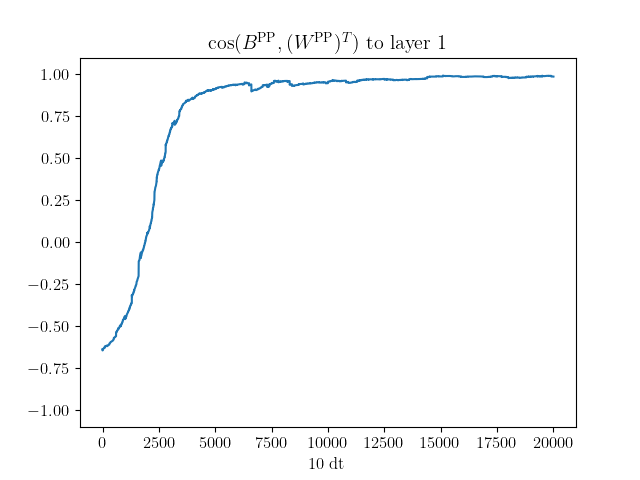

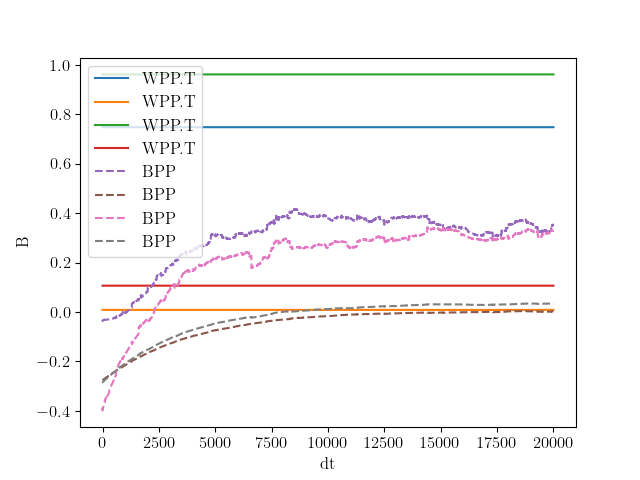

In [98]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc2.cos_WPPtrans_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    
    fig, ax = plt.subplots()
    ax.plot([WPP[i+1].T.ravel() for WPP in mc2.WPP_time_series], label="WPP.T")
    ax.plot([BPP[i].ravel() for BPP in mc2.BPP_time_series], label="BPP", ls='--')
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

We also check if the self-predicting state has been learnt correctly:

/var/folders/zb/q43ry99x69g19b1w0cyrrr700000gn/T/ipykernel_14119/4019307288.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


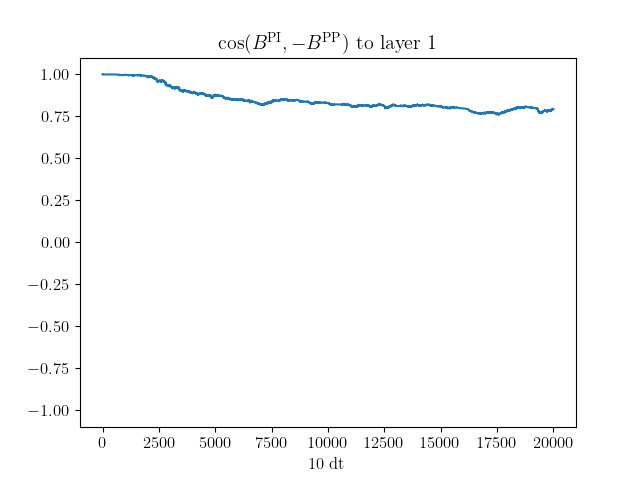

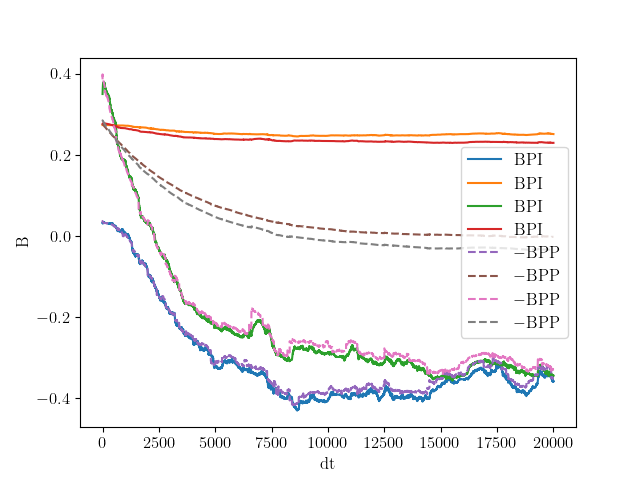

In [99]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc2.cos_BPI_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([BPI[i].ravel() for BPI in mc2.BPI_time_series], label="BPI")
    ax.plot([-BPP[i].ravel() for BPP in mc2.BPP_time_series], label="$-$BPP", linestyle='--')
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

# Learn $W$ and $B$ simultaneously (without final layer)

In this example, we construct a teacher and try to learn the same weights in 3 students, using, LDRL, BP and FA.

Net: [1-1-2]. Reason: if the hidden layer is a single neuron, there is no ambiguity as to when the 'correct' weights $W^\mathrm{PP}$ are learnt — the task is only learnt successfully if $W^\mathrm{PP}$ matches the teacher exactly.

In order to get a clear difference between the models, we initialise $W^\mathrm{PP}$ to hidden layer of the students with opposite signs as the teacher. We also fix all $W^\mathrm{PP}$ to the output layer to the same value as the teacher.

The self-predicting state is calculated dynamically, after setting it once at the beginning.

### Setup

In [141]:
# simulation settings

dt     = 1e-3 # in ms
dtxi   = 10 * dt
tausyn = 1 * dtxi
Tpres  = 1/dt * dt # present images for 1 ms
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 2000 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * |uP|
noise_scale = [5e-2]

In [142]:
np.random.seed(9876)

# Init model: weights, voltages

layers = [1, 1, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [0.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1)
eta_PI = [0.0] * (len(layers) - 1)

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 2, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-2, 2, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(0, 2, size=(layers[i], layers[-1]))) # << don't matter, get set to W.T anyways

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-2, 2, size=(layers[i], layers[-1])))
    
    
    
mc3_teacher = base_model(dt, Tpres, model='BP',
                         activation=relu, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_teacher.set_self_predicting_state()

In [143]:
# np.random.seed(123456)
np.random.seed(12345)

# Init model: weights, voltages

layers = [1, 1, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0,0] #200.0, 0]
eta_bw = [200.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1) # not needed, as WPP[1] = const.
eta_PI = [5.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [1e-5]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]

# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-2):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i]))) # << init fw weights positively, else relu blocks learning
WPP_init.append(mc3_teacher.WPP[1])

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-2, 2, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-2, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-2, 2, size=(layers[i], layers[-1])))

In [144]:
mc3_student_gated = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=True, 
                                 gate_regularizer=True,
                                 noise_mode='uP', model='LDRL', activation=relu, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_student_gated.set_self_predicting_state()

In [145]:
mc3_student_nogate = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=False, 
                                 gate_regularizer=False,
                                 noise_mode='uP', model='LDRL', activation=relu, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_student_nogate.set_self_predicting_state()

In [146]:
# check that student and teacher are not aligned already
print(mc3_student_nogate.WPP[0], mc3_teacher.WPP[0])

[[0.96451452]] [[0.91962473]]


### Simulation

In [147]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

# u2P of teacher will be target for student
target_time_series = []

# a little pre-training: run for one Tpres with random input, such that the
# somatic voltages converge
for i in range(int(Tpres/dt)):
    mc3_teacher.evolve_system(r0=r0_random[i])

# run real evaluation and save output
for i in range(len(r0_random)):
    mc3_teacher.evolve_system(r0=r0_random[i])
    target_time_series.append(copy.deepcopy(mc3_teacher.uP_breve[1]))

target_time_series = np.array(target_time_series)

/Users/km/Software/anaconda3/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


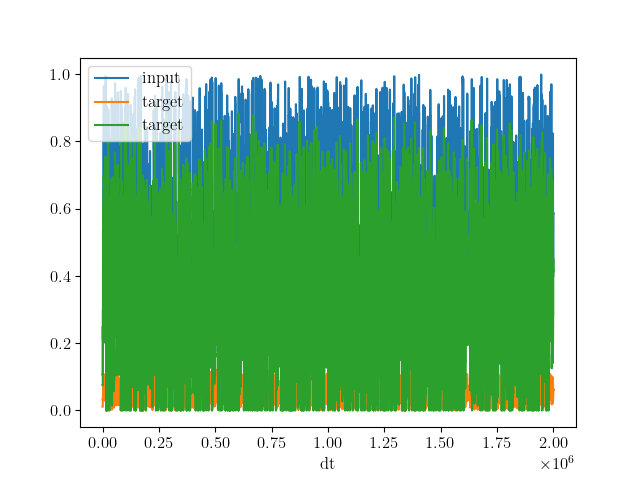

In [148]:
fig = plt.figure()
plt.plot(r0_random, label='input')
plt.plot(target_time_series, label='target')
plt.xlabel("dt")
plt.legend()
plt.show()

In [149]:
mc3_student_gated.init_record(rec_WPP=True, rec_WIP=True, rec_BPP=True, rec_BPI=True)

for i in range(len(r0_random)):
    mc3_student_gated.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt BPI and BPP
    mc3_student_gated.record_step()

/Users/km/owncloud/Projects Neuro/RtDeel simulations/RtDeep/microcircuit.py:245: RuntimeWarning: overflow encountered in matmul
  return BPP_mat @ rPvec + BPI_mat @ rIvec
/Users/km/owncloud/Projects Neuro/RtDeel simulations/RtDeep/microcircuit.py:401: RuntimeWarning: invalid value encountered in multiply
  self.dWPP[0] = self.dt * self.eta_fw[0] * np.outer(
/Users/km/owncloud/Projects Neuro/RtDeel simulations/RtDeep/microcircuit.py:539: RuntimeWarning: invalid value encountered in add
  self.uP[i] += self.duP[i]
/Users/km/owncloud/Projects Neuro/RtDeel simulations/RtDeep/microcircuit.py:555: RuntimeWarning: invalid value encountered in add
  self.BPI[i] += self.dBPI[i]
/Users/km/owncloud/Projects Neuro/RtDeel simulations/RtDeep/microcircuit.py:413: RuntimeWarning: invalid value encountered in subtract
  self.rP_breve[-1] - self.activation[-1](self.gbas / (self.gl + self.gbas) * self.vbas_old[-1]),
/Users/km/owncloud/Projects Neuro/RtDeel simulations/RtDeep/microcircuit.py:422: RuntimeW

KeyboardInterrupt: 

In [ ]:
mc3_student_nogate.init_record(rec_WPP=True, rec_WIP=True, rec_BPP=True, rec_BPI=True)

for i in range(len(r0_random)):
    mc3_student_nogate.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt BPI and BPP
    mc3_student_nogate.record_step()

In [ ]:
# fig = plt.figure()
# window = 5000
# plt.plot(moving_average(MSE_GT_time_series, window), label="LDRL", c='k')
# plt.plot(moving_average(MSE_noGT_time_series, window), label="no gate LDRL", c='k', linestyle='--')
# # plt.plot(moving_average(MSE_FA_time_series, window), label="FA", c='r')
# # plt.plot(moving_average(MSE_BP_time_series, window), label="BP", c='b')
# plt.title("MSE")
# plt.yscale('log')
# plt.legend()
# plt.show()

Check that dWPP is larger than dBPI and dBPP (whcih need to be of same order)

In [ ]:
# print(np.mean([mat[0] for mat in mc3_student_gated.dWIP_time_series]), '+-', np.std([mat[0] for mat in mc3_student_gated.dWIP_time_series]))
# print(np.mean([mat[0] for mat in mc3_student_gated.dWPP_time_series]), '+-', np.std([mat[0] for mat in mc3_student_gated.dWPP_time_series]))
# print(np.mean([mat[0] for mat in mc3_student_gated.dBPP_time_series]), '+-', np.std([mat[0] for mat in mc3_student_gated.dBPP_time_series]))
# print(np.mean([mat[0] for mat in mc3_student_gated.dBPI_time_series]), '+-', np.std([mat[0] for mat in mc3_student_gated.dBPI_time_series]))

Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [ ]:
mc3_student_gated.WPP_time_series[-1]

In [ ]:
mc3_student_gated.BPP_time_series[0]

In [ ]:
mc3_student_gated.BPP_time_series[-96540]

In [ ]:
len(mc3_student_gated.BPP_time_series)

In [ ]:
mc3_student_gated.dBPI

In [ ]:
cos_WPPteacher_WPPstudentGT = []
for i in range(0,len(mc3_student_gated.WPP_time_series[0])):
    cos_WPPteacher_WPPstudentGT.append(np.array([
        cos_sim(mc3_teacher.WPP[i], mc3_student_gated.WPP_time_series[j][i]) for j in range(0, len(mc3_student_gated.WPP_time_series), 10)
                           ]))
    
cos_WPPteacher_WPPstudentnoGT = []
for i in range(0,len(mc3_student_nogate.WPP_time_series[0])):
    cos_WPPteacher_WPPstudentnoGT.append(np.array([
        cos_sim(mc3_teacher.WPP[i], mc3_student_nogate.WPP_time_series[j][i]) for j in range(0, len(mc3_student_nogate.WPP_time_series), 10)
                           ]))
    
cos_BPP_WPPstudentGT = []
for i in range(0,len(mc3_student_gated.BPP_time_series[0])):
    cos_BPP_WPPstudentGT.append(np.array([
        cos_sim(mc3_student_gated.BPP_time_series[j][i], mc3_student_gated.WPP_time_series[j][i].T) for j in range(0, len(mc3_student_gated.BPP_time_series), 10)
                           ]))
    
cos_BPP_WPPstudentnoGT = []
for i in range(0,len(mc3_student_nogate.BPP_time_series[0])):
    cos_BPP_WPPstudentnoGT.append(np.array([
        cos_sim(mc3_student_nogate.BPP_time_series[j][i], mc3_student_nogate.WPP_time_series[j][i].T) for j in range(0, len(mc3_student_nogate.BPP_time_series), 10)
                           ]))

In [ ]:
for i in range(len(layers[0:-2])):
    fig, ax = plt.subplots()
    ax.plot(cos_BPP_WPPstudentGT[i], label="gated", c='red')
    ax.plot(cos_BPP_WPPstudentnoGT[i], label="no gate", c='blue')
    # ax.plot(cos_WPPteacher_WPPstudent[i], label="LDRL", c='black')
    # ax.plot(cos_WPPteacher_WPPstudentLO[i], label="LDRL with LO-pass", c='black', linestyle="--")
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([BPP[i].ravel() for BPP in mc3_student_gated.BPP_time_series], label="gated", c='red')
    ax.plot([WPP[i+1].ravel() for WPP in mc3_student_gated.WPP_time_series], label="gated", c='red', linestyle='--')
    ax.plot([BPP[i].ravel() for BPP in mc3_student_nogate.BPP_time_series], label="nogate", c='blue')
    ax.plot([WPP[i+1].ravel() for WPP in mc3_student_nogate.WPP_time_series], label="nogate", c='blue', linestyle='--')
    plt.yscale('linear')
    # label = '10 dt'
    # plt.xlabel(label)
    plt.title('$B^\mathrm{PP}$ and $(W^\mathrm{PP})^T$ to layer ' + str(i+1))
    # plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()


In [ ]:
for i in range(len(layers[0:-2])):
    # fig, ax = plt.subplots()
    # ax.plot(cos_WPPteacher_WPPstudentGT[i], label="FA", c='red')
    # ax.plot(cos_WPPteacher_WPPstudentnoGT[i], label="BP", c='blue')
    # # ax.plot(cos_WPPteacher_WPPstudent[i], label="LDRL", c='black')
    # # ax.plot(cos_WPPteacher_WPPstudentLO[i], label="LDRL with LO-pass", c='black', linestyle="--")
    # plt.yscale('linear')
    # label = '10 dt'
    # plt.xlabel(label)
    # plt.title('$\cos(W^\mathrm{PP}_\mathrm{teacher}, W^\mathrm{PP}_\mathrm{student})$ to layer ' + str(i+1))
    # plt.ylim(-1.1,1.1)
    # plt.legend()
    # plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([mc3_teacher.WPP[i].ravel() for WPP in mc3_student_nogate.WPP_time_series], label="teacher", c='green')
    ax.plot([WPP[i].ravel() for WPP in mc3_student_gated.WPP_time_series], label="gated", c='red')
    ax.plot([WPP[i].ravel() for WPP in mc3_student_nogate.WPP_time_series], label="nogate", c='blue')
    # ax.plot([WPP[i].ravel() for WPP in WPP_time_series], label="LDRL", c='black')
    # ax.plot([WPP[i].ravel() for WPP in WPP_LO_time_series], label="LDRL with LO-pass", c='black', linestyle="--")
    plt.yscale('linear')
    # label = '10 dt'
    # plt.xlabel(label)
    plt.title('$W^\mathrm{PP}_\mathrm{teacher}$ and $W^\mathrm{PP}_\mathrm{student}$ to layer ' + str(i+1))
    # plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()


# Learn $W$ and $B$ simultaneously -- full system

Same as before, but net is now [2-2-2].

### Setup

In [62]:
# simulation settings

dt     = 1e-3 # in ms
dtxi   = 10 * dt
tausyn = 10 * dtxi
Tpres  = 1/dt * dt # present images for 1 ms
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 100 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * max(|vapi|)
noise_scale = [5e-2]

In [63]:
np.random.seed(9876)

# Init model: weights, voltages

layers = [2, 2, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [0.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1)
eta_PI = [0.0] * (len(layers) - 1)

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 2, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-2, 2, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(0, 2, size=(layers[i], layers[-1]))) # << don't matter, get set to W.T anyways

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-2, 2, size=(layers[i], layers[-1])))
    
    
    
mc4_teacher = base_model(dt, Tpres, model='BP',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc4_teacher.set_self_predicting_state()

In [86]:
np.random.seed(123)

# Init model: weights, voltages

layers = [2, 2, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [200.0, 0]
eta_bw = [500.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1) # not needed, as WPP[1] = const.
eta_PI = [5.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [1e-5]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]

# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-2):
    WPP_init.append(np.random.uniform(-2, 0, size=(layers[i+1], layers[i]))) # << init fw weights netatively
    WPP_init.append(mc4_teacher.WPP[1])

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-2, 2, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-2, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-2, 2, size=(layers[i], layers[-1])))

In [87]:
mc4_student = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=False, model='LDRL',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc4_student.set_self_predicting_state()

In [88]:
# for i in range(int(Tpres/dt)):
#     mc4_student.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True)
#     mc4_student.set_self_predicting_state()

# print(np.mean(mc4_student.dWIP[0]), '+-', np.std(mc4_student.dWIP[0]))
# print(np.mean(mc4_student.dWPP[0]), '+-', np.std(mc4_student.dWPP[0]))
# print(np.mean(mc4_student.dBPI[0]), '+-', np.std(mc4_student.dBPI[0]))
# print(np.mean(mc4_student.dBPP[0]), '+-', np.std(mc4_student.dBPP[0]))

In [89]:
mc4_student_LO = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=True, model='LDRL',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc4_student.set_self_predicting_state()

In [90]:
mc4_student_BP = base_model(dt, Tpres, model='BP',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc4_student_BP.set_self_predicting_state()

In [91]:
mc4_student_FA = base_model(dt, Tpres, model='FA',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc4_student_FA.set_self_predicting_state()

In [92]:
# check that student and teacher are not aligned already
cos_sim(mc4_student_BP.WPP[0], mc4_teacher.WPP[0])

-0.8375646017387628

In [93]:
# we have set WPP to output layer to same matrix in all models
mc4_student_BP.WPP

[array([[-0.0384716 , -0.63034052],
        [-1.0381362 , -1.21576496]]),
 array([[0.35638437, 0.29852035],
        [0.52691908, 0.58945149]])]

In [94]:
mc4_teacher.WPP

[array([[0.91962473, 0.27375306],
        [1.89765152, 0.9824115 ]]),
 array([[0.35638437, 0.29852035],
        [0.52691908, 0.58945149]])]

### Simulation

In [95]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

# u2P of teacher will be target for student
target_time_series = []

# a little pre-training: run for one Tpres with random input, such that the
# somatic voltages converge
for i in range(int(Tpres/dt)):
    mc4_teacher.evolve_system(r0=r0_random[i])

# run real evaluation and save output
for i in range(len(r0_random)):
    mc4_teacher.evolve_system(r0=r0_random[i])
    target_time_series.append(copy.deepcopy(mc4_teacher.uP_breve[1]))

target_time_series = np.array(target_time_series)

In [96]:
# fig = plt.figure()
# plt.plot(r0_random, label='input')
# plt.plot(target_time_series, label='target')
# plt.xlabel("dt")
# plt.legend()
# plt.show()

In [97]:
WPP_FA_time_series = []
MSE_FA_time_series = []

for i in range(len(r0_random)):
    mc4_student_FA.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]]) # << adapt WIP, BPI and BPP
    # mc4_student_FA.set_self_predicting_state()
    
    WPP_FA_time_series.append(copy.deepcopy(mc4_student_FA.WPP))
    
    MSE_FA_time_series.append(MSE(mc4_student_FA.uP_breve[-1], target_time_series[i]))

In [98]:
WPP_BP_time_series = []
BPP_BP_time_series = []
MSE_BP_time_series = []

for i in range(len(r0_random)):
    mc4_student_BP.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]]) # << adapt WIP, BPI and BPP
    # mc4_student_BP.set_self_predicting_state()
    
    WPP_BP_time_series.append(copy.deepcopy(mc4_student_BP.WPP))
    BPP_BP_time_series.append(copy.deepcopy(mc4_student_BP.BPP))
    
    MSE_BP_time_series.append(MSE(mc4_student_BP.uP_breve[-1], target_time_series[i]))

In [99]:
WPP_LO_time_series = []
BPP_LO_time_series = []
MSE_LO_time_series = []

for i in range(len(r0_random)):
    mc4_student_LO.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]]) # << adapt WIP, BPI and BPP
    # mc4_student_LO.set_self_predicting_state()
    
    WPP_LO_time_series.append(copy.deepcopy(mc4_student_LO.WPP))
    BPP_LO_time_series.append(copy.deepcopy(mc4_student_LO.BPP))
    
    MSE_LO_time_series.append(MSE(mc4_student_LO.uP_breve[-1], target_time_series[i]))

In [100]:
u_time_series = []
# uIbreve_time_series = []
# uPbreve_time_series = []
rIbreve_time_series = []
rPbreve_time_series = []

WPP_time_series = []
BPP_time_series = []
WIP_time_series = []
BPI_time_series = []
dBPP_time_series = []
vapi_time_series = []
MSE_time_series = []

for i in range(len(r0_random)):
    mc4_student.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
    # mc4_student.set_self_predicting_state()
    
    rIbreve_time_series.append(copy.deepcopy(mc4_student.rI_breve))
    rPbreve_time_series.append(copy.deepcopy(mc4_student.rP_breve))
    # u_time_series.append(copy.deepcopy(mc4_student.get_voltages()))

    vapi_time_series.append(copy.deepcopy(mc4_student.vapi))
    WPP, WIP, BPP, BPI = mc4_student.get_weights()
    WPP_time_series.append(copy.deepcopy(WPP))
    BPP_time_series.append(copy.deepcopy(BPP))
    WIP_time_series.append(copy.deepcopy(WIP))
    BPI_time_series.append(copy.deepcopy(BPI))
    
    MSE_time_series.append(MSE(mc4_student.uP_breve[-1], target_time_series[i]))

# uP_time_series = [u[0] for u in u_time_series]
# uI_time_series = [u[1] for u in u_time_series]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/km/Software/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/zb/q43ry99x69g19b1w0cyrrr700000gn/T/ipykernel_52123/643936423.py", line 16, in <module>
    mc4_student.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
  File "/Users/km/owncloud/Projects Neuro/RtDeel simulations/RtDeep/microcircuit.py", line 505, in evolve_system
    self.Time = np.round(self.Time + self.dt, decimals=self.dt_decimals)
  File "<__array_function__ internals>", line 5, in round_
  File "/Users/km/Software/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 3709, in round_
    @array_function_dispatch(_around_dispatcher)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):

TypeError: object of type 'NoneType' has no len()

In [ ]:
fig = plt.figure()
window = 1000
plt.plot(moving_average(MSE_time_series, window), label="LDRL", c='k')
plt.plot(moving_average(MSE_LO_time_series, window), label="LDRL with LO-pass", c='k', linestyle='--')
plt.plot(moving_average(MSE_FA_time_series, window), label="FA", c='r')
plt.plot(moving_average(MSE_BP_time_series, window), label="BP", c='b')
plt.title("MSE")
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# fig = plt.figure()
# rP = [rP[0][0] for rP in vapi_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# rP = [rP[0][1] for rP in vapi_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# plt.title("vapi layer 1")
# plt.show()

# fig = plt.figure()
# rP = [rP[0][0] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# rP = [rP[0][1] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# plt.title("rPbreve layer 1")
# plt.show()

# fig = plt.figure()
# rP = [rP[1] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^P)}$")
# plt.plot(np.array(rIbreve_time_series[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^I)}$")
# plt.legend()
# # plt.gca().set_xlim(left=int(Tpres/dt))
# plt.xlabel('dt')
# plt.show()


# # fig = plt.figure()
# # xibreve = [xibreve[0] for xibreve in xibreve_time_series]
# # plt.plot(np.array(xibreve[0*int(Tpres/dt):]), label=["$\\breve{\\xi_1}$","$\\breve{\\xi_2}$"])
# # plt.title("Lookahead of noise")
# # plt.xlabel('dt')
# # plt.legend()
# # plt.show()

Now, let's check that WPP has been learnt correctly:

In [ ]:
cos_WPPteacher_WPPstudentFA = []
for i in range(0,len(WPP_time_series[0])):
    cos_WPPteacher_WPPstudentFA.append(np.array([
        cos_sim(mc4_teacher.WPP[i], WPP_FA_time_series[j][i]) for j in range(0, len(WPP_time_series), 10)
                           ]))
    
cos_WPPteacher_WPPstudentLO = []
for i in range(0,len(WPP_time_series[0])):
    cos_WPPteacher_WPPstudentLO.append(np.array([
        cos_sim(mc4_teacher.WPP[i], WPP_LO_time_series[j][i]) for j in range(0, len(WPP_time_series), 10)
                           ]))
    
cos_WPPteacher_WPPstudentBP = []
for i in range(0,len(WPP_time_series[0])):
    cos_WPPteacher_WPPstudentBP.append(np.array([
        cos_sim(mc4_teacher.WPP[i], WPP_BP_time_series[j][i]) for j in range(0, len(WPP_time_series), 10)
                           ]))

cos_WPPteacher_WPPstudent = []
for i in range(0,len(WPP_time_series[0])):
    cos_WPPteacher_WPPstudent.append(np.array([
        cos_sim(mc4_teacher.WPP[i], WPP_time_series[j][i]) for j in range(0, len(WPP_time_series), 10)
                           ]))
    
cos_BPI_BPP = []
for i in range(len(BPI_time_series[0])):
    cos_BPI_BPP.append(np.array([
        cos_sim(BPI_time_series[j][i], -BPP_time_series[j][i]) for j in range(0, len(BPI_time_series), 10)
                           ]))
    
cos_WIP_WPP = []
for i in range(len(WIP_time_series[0])):
    cos_WIP_WPP.append(np.array([
        cos_sim(WIP_time_series[j][i], WPP_time_series[j][i+1]) for j in range(0, len(WIP_time_series), 10)
                           ]))
    
cos_WPPtrans_BPP = []
for i in range(len(BPP_time_series[0])):
    cos_WPPtrans_BPP.append(np.array([
        cos_sim(BPP_time_series[j][i], WPP_time_series[j][i+1].T) for j in range(0, len(BPP_time_series), 10)
                           ]))

In [ ]:
for i in range(len(layers[0:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WPPteacher_WPPstudentFA[i], label="FA", c='red')
    ax.plot(cos_WPPteacher_WPPstudentBP[i], label="BP", c='blue')
    ax.plot(cos_WPPteacher_WPPstudent[i], label="LDRL", c='black')
    ax.plot(cos_WPPteacher_WPPstudentLO[i], label="LDRL with LO-pass", c='black', linestyle="--")
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{PP}_\mathrm{teacher}, W^\mathrm{PP}_\mathrm{student})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([mc4_teacher.WPP[i].ravel() for WPP in WPP_FA_time_series], label="teacher", c='green')
    ax.plot([WPP[i].ravel() for WPP in WPP_FA_time_series], label="FA", c='red')
    ax.plot([WPP[i].ravel() for WPP in WPP_BP_time_series], label="BP", c='blue')
    ax.plot([WPP[i].ravel() for WPP in WPP_time_series], label="LDRL", c='black')
    ax.plot([WPP[i].ravel() for WPP in WPP_LO_time_series], label="LDRL with LO-pass", c='black', linestyle="--")
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$W^\mathrm{PP}_\mathrm{teacher}$ and $W^\mathrm{PP}_\mathrm{student}$ to layer ' + str(i+1))
    # plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()
    

# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1].T for WPP in WPP_time_series]).ravel(), label="WPP.T")
# ax.plot(np.array(BPP_time_series).ravel(), label="BPP")
# plt.yscale('linear')
# label = 'dt'
# plt.xlabel(label)
# plt.ylabel("B")
# plt.legend()
# # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
# plt.show()

In [ ]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WPPtrans_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    
    fig, ax = plt.subplots()
    ax.plot([WPP[i+1].T.ravel() for WPP in WPP_time_series], label="WPP.T")
    ax.plot([BPP[i].ravel() for BPP in BPP_time_series], label="BPP")
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

Check whether the self-predicting state holds:

In [ ]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_BPI_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([BPI[i].ravel() for BPI in BPI_time_series], label="BPI", linestyle='--')
    ax.plot([-BPP[i].ravel() for BPP in BPP_time_series], label="-BPP")
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

In [ ]:
# for i in range(len(layers[1:-1])):
#     fig, ax = plt.subplots()
#     ax.plot(cos_WIP_WPP[i])
#     plt.yscale('linear')
#     label = '10 dt'
#     plt.xlabel(label)
#     plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
#     plt.ylim(-1.1,1.1)
#     plt.show()


# # fig, ax = plt.subplots()
# # ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# # ax.plot(np.array(WIP_time_series).ravel())
# # plt.yscale('linear')
# # label = 'dt'
# # # plt.legend()
# # plt.xlabel(label)
# # plt.show()